In [21]:
import numpy as np
import pandas as pd
import tensorflow as tf
from matplotlib import pyplot as plt

In [2]:
# Parcel irrigation data
irrigation = pd.read_csv('irrigation_machine.csv').drop('Unnamed: 0', axis=1)
parcel_columns = ['parcel_0', 'parcel_1', 'parcel_2']
parcels = irrigation[parcel_columns].values
sensors = irrigation.drop(parcel_columns, axis=1).values

from sklearn.model_selection import train_test_split
sensors_train, sensors_test, parcels_train, parcels_test = \
  train_test_split(sensors, parcels, test_size=0.3)

In [3]:
# Load parcel irrigation model to study its behaviour
from tensorflow.keras.models import load_model

irrigation_model = load_model('best_model.hdf5')
irrigation_model.summary()

2021-11-23 19:26:22.969830: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2021-11-23 19:26:22.969932: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2021-11-23 19:26:22.969982: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (DESKTOP-FC4EGDV): /proc/driver/nvidia/version does not exist
2021-11-23 19:26:22.970452: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_5 (Dense)              (None, 128)               2688      
_________________________________________________________________
dropout (Dropout)            (None, 128)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 128)               16512     
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_7 (Dense)              (None, 128)               16512     
_________________________________________________________________
dropout_2 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_8 (Dense)              (None, 128)              

In [4]:
# Access the model's layers
print(irrigation_model.layers)

# Filter dense layers
from tensorflow.keras.layers import Dense

dense_layers = [layer for layer in irrigation_model.layers if type(layer) == Dense]
print('\n', dense_layers)

[<keras.layers.core.Dense object at 0x7fcd720ae820>, <keras.layers.core.Dropout object at 0x7fcd687d48b0>, <keras.layers.core.Dense object at 0x7fcd687d4dc0>, <keras.layers.core.Dropout object at 0x7fcd687959a0>, <keras.layers.core.Dense object at 0x7fcd687a2640>, <keras.layers.core.Dropout object at 0x7fcd687a2430>, <keras.layers.core.Dense object at 0x7fcd687ac3a0>, <keras.layers.core.Dropout object at 0x7fcd687acf70>, <keras.layers.core.Dense object at 0x7fcd687b2bb0>, <keras.layers.core.Dropout object at 0x7fcd687b23a0>, <keras.layers.core.Dense object at 0x7fcd6873a880>]

 [<keras.layers.core.Dense object at 0x7fcd720ae820>, <keras.layers.core.Dense object at 0x7fcd687d4dc0>, <keras.layers.core.Dense object at 0x7fcd687a2640>, <keras.layers.core.Dense object at 0x7fcd687ac3a0>, <keras.layers.core.Dense object at 0x7fcd687b2bb0>, <keras.layers.core.Dense object at 0x7fcd6873a880>]


In [5]:
from tensorflow.keras.models import Model

def transformation_history(data):
  # Accumulate the different transformations the data undergoes when we perform forward propagation
  prediction_steps = [data]
  for dense_layer in dense_layers:
    # Extract input and output tensors from the model
    inputs, outputs = irrigation_model.input, dense_layer.output
    # Use information held by Keras to connect this tensors, through the irrigation model's layers
    intermediate_model = Model(inputs=inputs, outputs=outputs)
    # Predict using this sub-model in order to inspect the behaviour of the dense layer
    intermediate_predictions = intermediate_model.predict(sensors_train)

    prediction_steps.append(intermediate_predictions)
    
  return prediction_steps

prediction_steps = transformation_history(sensors_train)

2021-11-23 19:26:23.720228: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


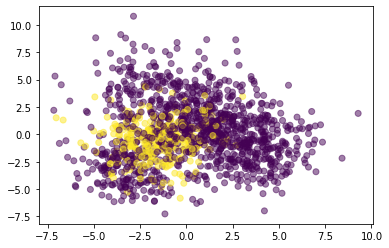

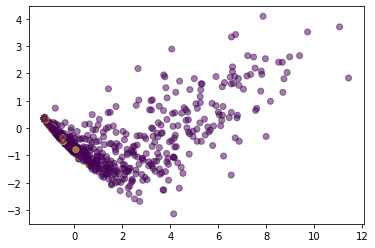

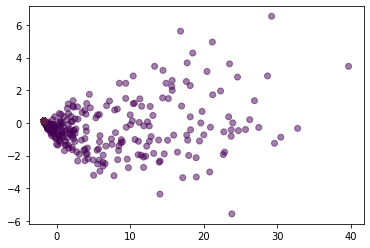

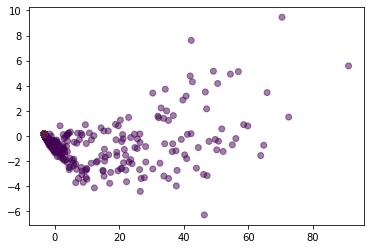

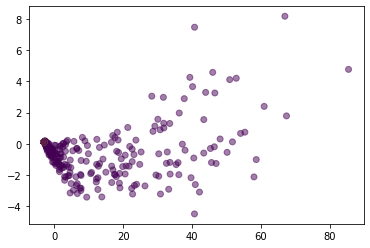

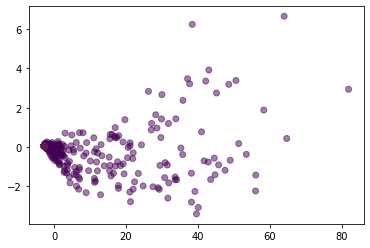

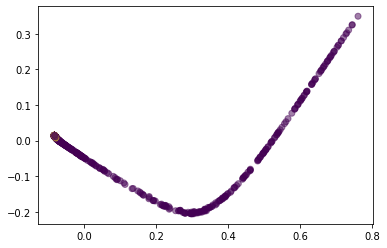

In [6]:
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

def embedding_plot(datasets, categories, embedder=None):
  if not embedder: embedder = PCA(n_components=2)

  embeddings = [embedder.fit_transform(dataset) for dataset in datasets]

  for embedding, category in zip(embeddings, categories):
    plt.figure()
    plt.scatter(x=embedding[:,0], y=embedding[:,1], c=category, alpha=0.5)
    plt.plot()


embedding_plot(prediction_steps, len(prediction_steps) * [parcels_train[:,2]])

In [7]:
# MNIST dataset of handwritten digits
from tensorflow.keras.utils import to_categorical



pixels = np.load('digits_pixels.npy')

# We study the data
print(min([min(pixel_vector) for pixel_vector in pixels]))
print(max([max(pixel_vector) for pixel_vector in pixels]))
# Normalize values accordingly
pixels /= 16.0

n_cols = pixels.shape[1]
input_shape = (n_cols,)
numbers = to_categorical(np.load('digits_target.npy'))

from sklearn.model_selection import train_test_split

pixels_train, pixels_test, numbers_train, numbers_test = \
  train_test_split(pixels, numbers, test_size=0.3)

0.0
16.0


In [8]:
# Autoencoder
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

autoencoder = Sequential([
  Dense(n_cols // 6, activation='relu', input_shape=input_shape),
  Dense(n_cols, activation='sigmoid')
])
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')
autoencoder.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 10)                650       
_________________________________________________________________
dense_1 (Dense)              (None, 64)                704       
Total params: 1,354
Trainable params: 1,354
Non-trainable params: 0
_________________________________________________________________


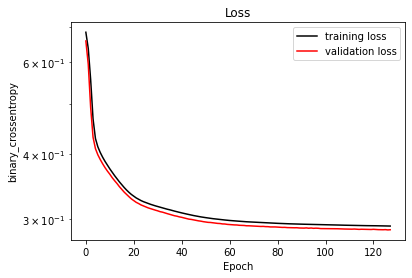

In [9]:
# Train
history = autoencoder.fit(pixels_train, pixels_train, epochs=2**7, validation_split=0.1, verbose=False)

plt.plot(history.history['loss'], color='black', label='training loss')
plt.plot(history.history['val_loss'], color='red', label='validation loss')
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('binary_crossentropy')
plt.yscale('log')
plt.legend()

In [10]:
# Inspect model output
print(pixels_train.shape)
print(pixels_train[0].reshape(1, -1).shape)

autoencoder.predict(pixels_train[0].reshape(1, -1))

(1257, 64)
(1, 64)


array([[3.8555509e-06, 1.0279552e-04, 1.0370642e-02, 2.4709737e-01,
        7.1644467e-01, 1.3498893e-01, 9.6532702e-03, 2.4303794e-04,
        8.6698865e-06, 6.2364340e-04, 1.8016875e-02, 9.1198421e-01,
        8.2301813e-01, 8.7453663e-02, 3.3456981e-02, 1.4570355e-03,
        5.0269655e-06, 5.3344667e-03, 3.0532968e-01, 9.6530724e-01,
        3.7501687e-01, 1.4872101e-01, 1.2206218e-01, 2.4883151e-03,
        2.6750118e-05, 1.0840088e-01, 7.6474446e-01, 4.0791121e-01,
        1.6794890e-01, 5.7447505e-01, 1.9186822e-01, 7.7394368e-05,
        4.4507342e-05, 4.4902131e-01, 9.4792759e-01, 4.2428857e-01,
        7.4456668e-01, 9.3528247e-01, 3.5456914e-01, 2.3770435e-05,
        2.6986897e-03, 5.4496402e-01, 9.1814786e-01, 7.4625504e-01,
        9.0441662e-01, 9.1475201e-01, 2.5414965e-01, 2.2351742e-03,
        7.7557564e-04, 5.5739492e-02, 2.0379865e-01, 5.0314516e-01,
        9.3406165e-01, 7.0263761e-01, 8.5584015e-02, 6.2372684e-03,
        2.0674517e-05, 2.0691752e-04, 8.6576343e

4


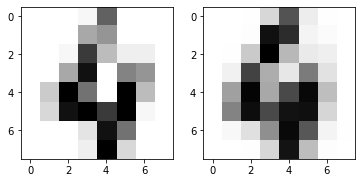

2


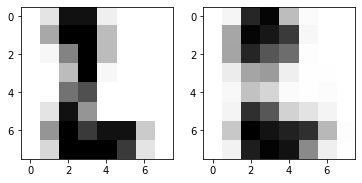

0


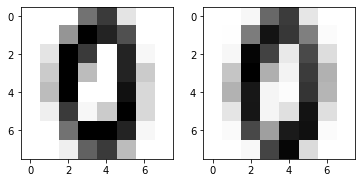

3


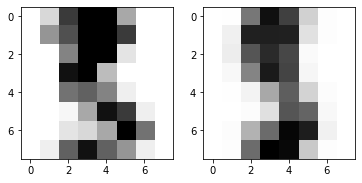

4


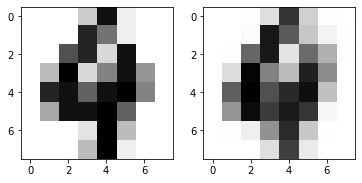

9


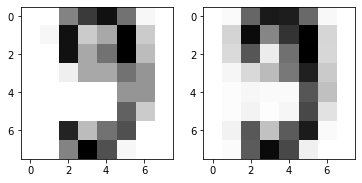

5


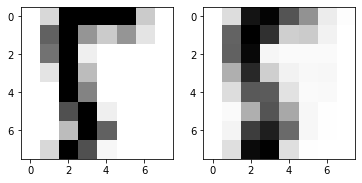

6


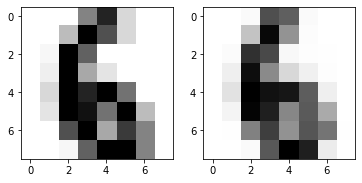

5


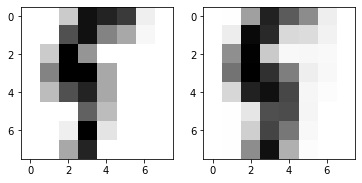

1


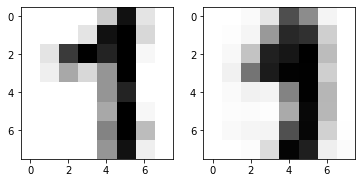

In [11]:
# Playing with pixels

def autoencode(pixel_vector):
  return autoencoder.predict(pixel_vector.reshape(1, -1))


def print_autoencoded_digit(pixel_vector):
  fig, axs = plt.subplots(nrows=1, ncols=2)  
  axs[0].imshow(pixel_vector.reshape(8, 8), cmap='Greys')
  axs[1].imshow(autoencode(pixel_vector).reshape(8, 8), cmap='Greys')
  plt.show()


def print_label(digit_distribution):
  print(np.argmax(digit_distribution))


# Inspect autoencoder outputs
for i in range(10):
  print_label(numbers_train[i])
  print_autoencoded_digit(pixels_train[i])

4


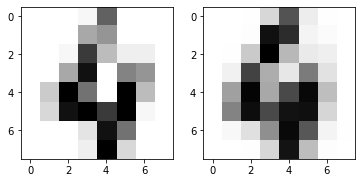

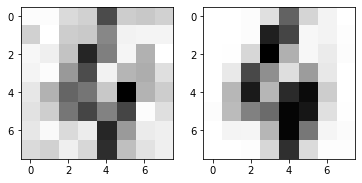




2


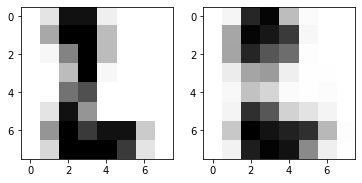

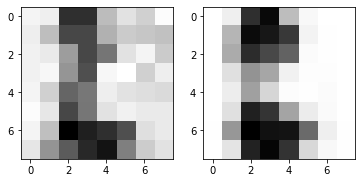




0


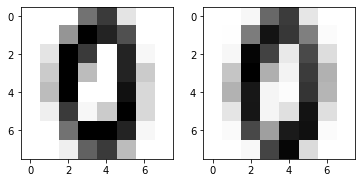

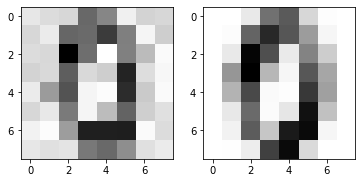




3


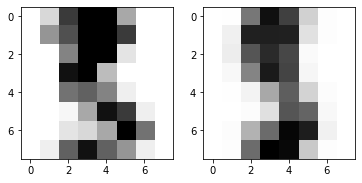

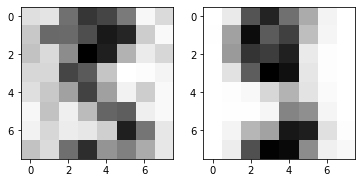




4


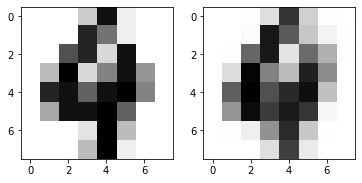

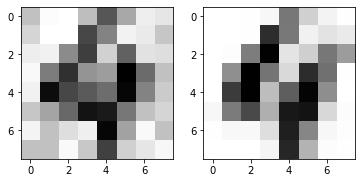




9


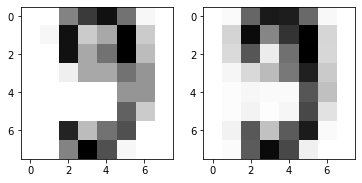

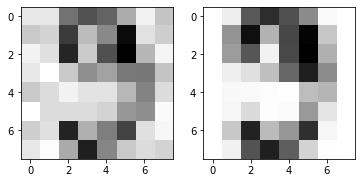




5


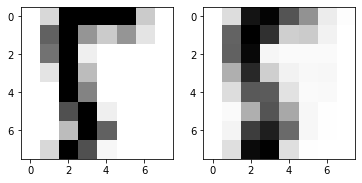

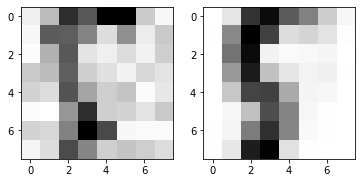




6


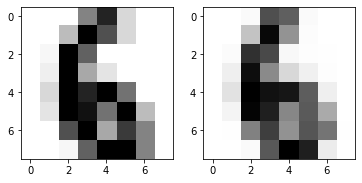

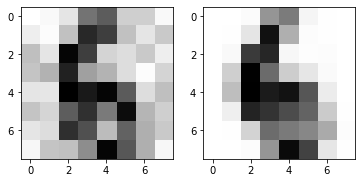




5


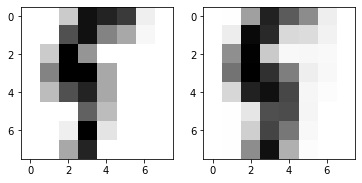

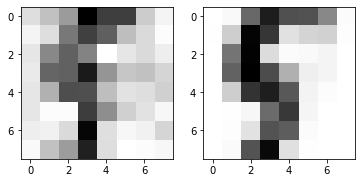




1


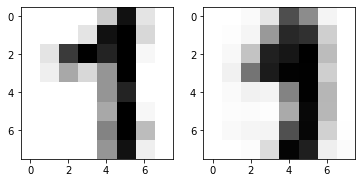

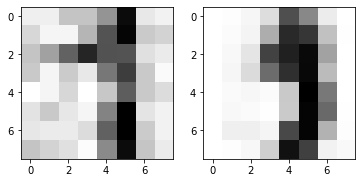

In [12]:
# Introuce noise into images, then recover them using autoencoding
def perturb(pixel_vector, epsilon=2**-5):
  noise = np.float32(np.random.randint(low=0, high=17, size=len(pixel_vector)))
  perturbed_pixel_vector = (1.0 - epsilon) * pixel_vector + epsilon * noise
  
  return perturbed_pixel_vector

# Autoencode both the digit and the perturbed digit
for i in range(10):
  digit_distribution = numbers_train[i]
  pixel_vector = pixels_train[i]

  print_label(digit_distribution)
  print_autoencoded_digit(pixel_vector)
  print_autoencoded_digit(perturb(pixel_vector))
  print('\n\n')

In [13]:
# Extract the encoder from the autoencoder
from tensorflow.keras.models import Model

encoder_inputs = autoencoder.inputs
encoder_outputs = autoencoder.layers[0].output
encoder = Model(inputs=encoder_inputs, outputs=encoder_outputs)

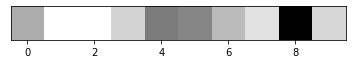

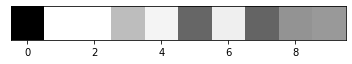

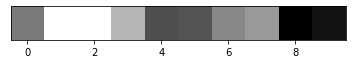

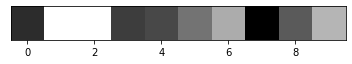

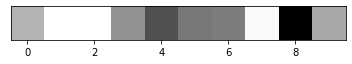

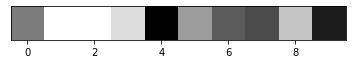

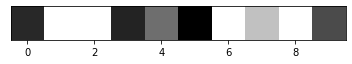

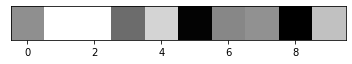

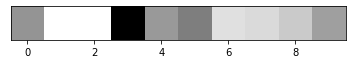

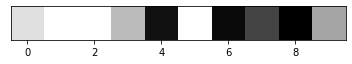

In [14]:
# Inspect codes
codes_train = encoder.predict(pixels_train)

for code in codes_train[:10]:
  fig, ax = plt.subplots()
  plt.imshow(code.reshape(1, -1), cmap='Greys')
  plt.yticks([])
  plt.plot()

In [15]:
# MNIST dataset of handwritten digits
from tensorflow.keras.utils import to_categorical

data = np.load('digits_pixels.npy')

# We study the data
print(
  min([min(vector) for vector in data]),
  max([max(vector) for vector in data])
)
# Normalize values accordingly
data /= 16.0

pixel_vectors = data
n_pixels = pixel_vectors.shape[1]
digits = to_categorical(np.load('digits_target.npy'))

from sklearn.model_selection import train_test_split

pixel_vectors_train, pixel_vectors_test, digits_train, digits_test = \
  train_test_split(pixel_vectors, digits, test_size=0.3)

image_shape = (8, 8, 1)

def to_image_array(vectors):
  return np.array([vector.reshape(*image_shape) for vector in vectors])

pixels_train, pixels_test = to_image_array(pixel_vectors_train), to_image_array(pixel_vectors_test)

0.0 16.0


In [16]:
# Building a CNN model
from tensorflow.keras.layers import Dense, Conv2D, Flatten

dense_model = Sequential([
  Dense(50, activation='relu', input_shape=(n_pixels,), kernel_initializer='normal'),
  Dense(50, activation='relu', kernel_initializer='normal'),
  Dense(50, activation='relu', kernel_initializer='normal'),
  Dense(10, activation='softmax', kernel_initializer='normal')
])
dense_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
print(dense_model.summary())

conv_model = Sequential([
  Conv2D(filters=2**3, kernel_size=3, activation='relu', input_shape=(8, 8, 1)),
  Conv2D(filters=2**4, kernel_size=3, activation='relu'),
  Flatten(),
  Dense(25, activation='relu'),
  Dense(10, activation='softmax')
])
conv_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
print(conv_model.summary())

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2 (Dense)              (None, 50)                3250      
_________________________________________________________________
dense_3 (Dense)              (None, 50)                2550      
_________________________________________________________________
dense_4 (Dense)              (None, 50)                2550      
_________________________________________________________________
dense_5 (Dense)              (None, 10)                510       
Total params: 8,860
Trainable params: 8,860
Non-trainable params: 0
_________________________________________________________________
None
Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 6, 6, 8)           80        
_________________________

In [17]:
dense_history = dense_model.fit(pixel_vectors_train, digits_train, validation_split=0.1, epochs=2**5, verbose=False)
conv_history = conv_model.fit(pixels_train, digits_train, validation_split=0.1, epochs=2**5, verbose=False)

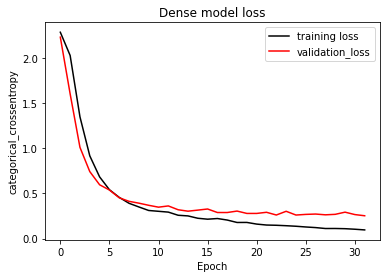

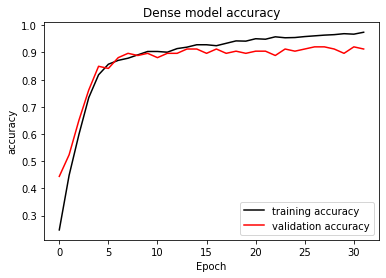

In [18]:
plt.plot(dense_history.history['loss'], color='black', label='training loss')
plt.plot(dense_history.history['val_loss'], color='red', label='validation_loss')
plt.title('Dense model loss')
plt.xlabel('Epoch')
plt.ylabel('categorical_crossentropy')
plt.legend()
plt.show()

plt.plot(dense_history.history['accuracy'], color='black', label='training accuracy')
plt.plot(dense_history.history['val_accuracy'], color='red', label='validation accuracy')
plt.title('Dense model accuracy')
plt.xlabel('Epoch')
plt.ylabel('accuracy')
plt.legend()
plt.show()

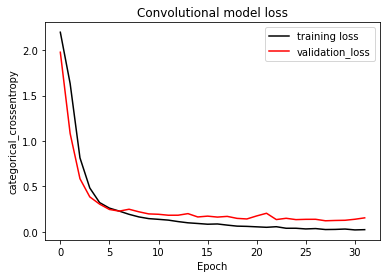

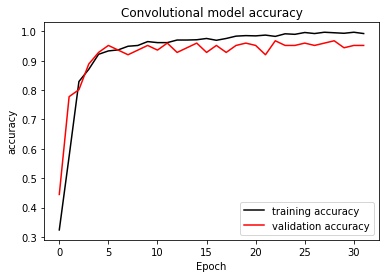

In [19]:
plt.plot(conv_history.history['loss'], color='black', label='training loss')
plt.plot(conv_history.history['val_loss'], color='red', label='validation_loss')
plt.title('Convolutional model loss')
plt.xlabel('Epoch')
plt.ylabel('categorical_crossentropy')
plt.legend()
plt.show()

plt.plot(conv_history.history['accuracy'], color='black', label='training accuracy')
plt.plot(conv_history.history['val_accuracy'], color='red', label='validation accuracy')
plt.title('Convolutional model accuracy')
plt.xlabel('Epoch')
plt.ylabel('accuracy')
plt.legend()
plt.show()

In [20]:
dense_model.evaluate(pixel_vectors_test, digits_test)
conv_model.evaluate(pixels_test, digits_test)

17/17 [==============================] - 0s 4ms/step - loss: 0.1244 - accuracy: 0.9648


[0.12435749173164368, 0.9648148417472839]

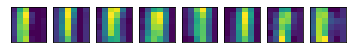

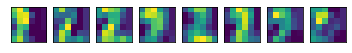

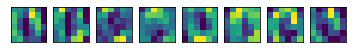

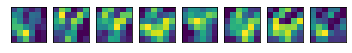

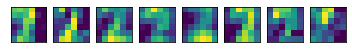

In [21]:
# Explore the convolutional layers
intermediate_layer_model = Model(inputs=conv_model.input, outputs=conv_model.layers[0].output)
outputs = intermediate_layer_model.predict(pixels_train)

for output in outputs[:5]:
  n_filters = output.shape[2]
  filter_outputs = [output[:, :, i] for i in range(n_filters)]

  fig, axs = plt.subplots(ncols=n_filters, sharex=True, sharey=True)
  plt.xticks([]); plt.yticks([])
  for ax, filter_output in zip(axs, filter_outputs):
    ax.imshow(filter_output)

  plt.plot()

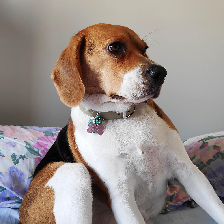

In [22]:
# Image processing and ResNet50
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.resnet50 import preprocess_input

def image_preprocessing(img_path):
  img = image.load_img(img_path, target_size=(224, 224))
  img_array = image.img_to_array(img)
  img_expanded = np.expand_dims(img_array, axis=0)
  img_ready = preprocess_input(img_expanded)
  
  return img_ready
  

# Load the image with the right target size for the ResNet50 model
beagle = image.load_img('dog.png', target_size=(224, 224))
swimming_pool = image.load_img('piscina.jpeg', target_size=(224, 224))
beagle

In [23]:
beagle_array = image.img_to_array(beagle)
swimming_pool_array = image.img_to_array(swimming_pool)
beagle_array.shape

(224, 224, 3)

In [24]:
# Expand the dimensions of the image, this is so that it fits the expected model input format
beagle_expanded = np.expand_dims(beagle_array, axis=0)
swimming_pool_expanded = np.expand_dims(swimming_pool_array, axis=0)

In [25]:
# Preprocess the image as needed for the ResNet50 model
beagle_ready = preprocess_input(beagle_expanded)
swimming_pool_ready = preprocess_input(swimming_pool_expanded)
beagle_ready

array([[[[ 23.060997 ,  15.221001 ,  11.32     ],
         [ 26.060997 ,  18.221    ,  14.32     ],
         [ 30.060997 ,  22.221    ,  18.32     ],
         ...,
         [ 62.060997 ,  62.221    ,  63.32     ],
         [ 62.060997 ,  62.221    ,  63.32     ],
         [ 62.060997 ,  62.221    ,  63.32     ]],

        [[ 23.060997 ,  15.221001 ,  11.32     ],
         [ 24.060997 ,  16.221    ,  12.32     ],
         [ 26.060997 ,  19.221    ,  15.32     ],
         ...,
         [ 62.060997 ,  62.221    ,  63.32     ],
         [ 62.060997 ,  62.221    ,  63.32     ],
         [ 62.060997 ,  62.221    ,  63.32     ]],

        [[ 21.060997 ,  12.221001 ,  10.32     ],
         [ 24.060997 ,  16.221    ,  11.32     ],
         [ 22.060997 ,  16.221    ,  12.32     ],
         ...,
         [ 62.060997 ,  62.221    ,  63.32     ],
         [ 62.060997 ,  62.221    ,  63.32     ],
         [ 62.060997 ,  62.221    ,  63.32     ]],

        ...,

        [[ 65.061    ,  19.221    ,  -

In [26]:
from tensorflow.keras.applications.resnet50 import ResNet50, decode_predictions

# Instantiate a ResNet50 model with 'imagenet' weights
model = ResNet50(weights='imagenet')

In [27]:
# Predict with ResNet50 on your already processed img
beagle_preds = model.predict(beagle_ready)
swimming_pool_preds = model.predict(swimming_pool_ready)
mora_preds = model.predict(image_preprocessing('mora.jpeg'))
titi_preds = model.predict(image_preprocessing('titi.jpeg'))

# Decode the first 3 predictions
print('Beagle predictions')
print(decode_predictions(beagle_preds, top=3))

print('Swimming pool predictions')
print(decode_predictions(swimming_pool_preds, top=3))

print('Cat predictions')
print(decode_predictions(mora_preds, top=3))

print('Titi predictions')
print(decode_predictions(titi_preds, top=3))

Beagle predictions
[[('n02088364', 'beagle', 0.90737605), ('n02089867', 'Walker_hound', 0.066266924), ('n02089973', 'English_foxhound', 0.018850928)]]
Swimming pool predictions
[[('n03956157', 'planetarium', 0.14430545), ('n03160309', 'dam', 0.13900568), ('n03982430', 'pool_table', 0.09645554)]]
Cat predictions
[[('n01882714', 'koala', 0.1810802), ('n01877812', 'wallaby', 0.13226132), ('n02123597', 'Siamese_cat', 0.11695253)]]
Titi predictions
[[('n02113712', 'miniature_poodle', 0.51644284), ('n02113624', 'toy_poodle', 0.26724082), ('n02085936', 'Maltese_dog', 0.19239697)]]


In [1]:
# LSTM Units, RNNs

text = 'Hi this is a small sentence'

# We choose a sequence length
seq_len = 3

# Split text into a list of words
words = text.split()

# Make lines
lines = []
for i in range(seq_len, len(words) + 1):
  line = ' '.join(words[i - seq_len:i])
  lines.append(line)

from keras.preprocessing.text import Tokenizer

# Instantiate Tokenizer
tokenizer = Tokenizer()

# Fit it on the previous lines
tokenizer.fit_on_texts(lines)

# Check out the dictionary constructed
print(tokenizer.index_word)

# Turn the lines into numeric sequences
sequences = tokenizer.texts_to_sequences(lines)

2021-11-23 19:55:52.889196: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2021-11-23 19:55:52.889304: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


{1: 'is', 2: 'a', 3: 'this', 4: 'small', 5: 'hi', 6: 'sentence'}


In [3]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Embedding

vocab_size = len(tokenizer.index_word) + 1

model = Sequential([
  Embedding(input_dim=vocab_size, output_dim=8, input_length=2),
  LSTM(8),
  Dense(8, activation='relu'),
  Dense(vocab_size, activation='softmax')
])

2021-11-23 20:03:49.769302: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2021-11-23 20:03:49.769679: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2021-11-23 20:03:49.769827: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (DESKTOP-FC4EGDV): /proc/driver/nvidia/version does not exist
2021-11-23 20:03:49.770763: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [33]:
# Prepare sequences of text
text = 'it is not the strength of the body but the strength of the spirit it is useless to meet revenge with revenge it will heal nothing even the smallest person can change the course of history all we have to decide is what to do with the time that is given us the burned hand teaches best after that advice about fire goes to the heart'

# Split text into an array of words
words = text.split()

# Make sentences of 4 words each, moving one word at a time
sentences = []
for i in range(4, len(words)):
  sentences.append(' '.join(words[i-4:i]))

# Instantiate a Tokenizer, then fit it on the sentences
from tensorflow.keras.preprocessing.text import Tokenizer

tokenizer = Tokenizer()
tokenizer.fit_on_texts(sentences)

# Get vocabulary size
codes = tokenizer.index_word.keys()
print(min(codes), max(codes))
vocab_size = len(codes)
print(f'{vocab_size=}')

# Turn sentences into a sequence of numbers
sequences = tokenizer.texts_to_sequences(sentences)

from itertools import islice
for sentence, sequence in islice(zip(sentences, sequences), 5):
  print(sentence); print(sequence); print()

1 43
vocab_size=43
it is not the
[5, 2, 42, 1]

is not the strength
[2, 42, 1, 6]

not the strength of
[42, 1, 6, 4]

the strength of the
[1, 6, 4, 1]

strength of the body
[6, 4, 1, 10]



In [74]:
from tensorflow.keras.utils import to_categorical

# Very annoyingly, out Tokenizer uses codes 1...n
# And our categorical variable processor uses codes 0...n-1
# Sigh
data = np.array(sequences) - 1

predictors = np.array([sequence[:3] for sequence in data])
targets = to_categorical([sequence[3] for sequence in data])

# Set the correct data type
predictors, targets = np.float32(predictors), np.float32(targets)

In [75]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense

model = Sequential([
  Embedding(input_dim=vocab_size, input_length=3, output_dim=8),
  LSTM(32),
  Dense(32, activation='relu'),
  Dense(vocab_size, activation='softmax')
])
model.compile(optimizer='adam', loss='categorical_crossentropy')

In [76]:
history = model.fit(predictors, targets, validation_split=.1, epochs=2**8, verbose=False)

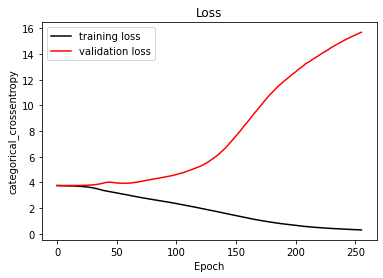

In [77]:
plt.plot(history.history['loss'], color='black', label='training loss')
plt.plot(history.history['val_loss'], color='red', label='validation loss')
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('categorical_crossentropy')
plt.legend()
plt.show()

In [79]:
# Decode the model's predictions
def predict_text(test_text):
  # Turn the text into a sequence of numbers
  test_seq = tokenizer.texts_to_sequences([test_text])
  # Use the data type and code that our model needs
  test_seq = np.array(test_seq) - 1
  # Use the model to get a probability distribution over the vocabulary
  token_distribution = model.predict(test_seq)
  # Get the highest probability token
  pred = np.argmax(token_distribution, axis=1)[0]
  # Turn the prediction into a token
  token = int(pred + 1)
  # Retrieve the word that maps to the prediction
  word = tokenizer.index_word[token]
  
  return word

print('meet revenge with', predict_text('meet revenge with'))
print('the course of', predict_text('the course of'))
print('strength of the', predict_text('strength of the'))

meet revenge with revenge
the course of history
strength of the spirit
